## Install Required Libraries

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Load Data

In [3]:
# Load the cleaned dataset with sentiment
df = pd.read_csv('cleaned_01_with_sentiment.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nUnique candidates: {df['name'].nunique()}")
print(f"\nFirst few rows:")
display(df.head())

Dataset shape: (119, 10)

Columns: ['candidate_id', 'name', 'party', 'municipality', 'question_number', 'question_text', 'answer_text', 'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_category']

Unique candidates: 119

First few rows:


,candidate_id,name,party,municipality,question_number,question_text,answer_text,sentiment_polarity,sentiment_subjectivity,sentiment_category
0,5725,Sine Heltberg,A,Frederiksberg Kommune,6,NaN,Se Sines svar1/19| økonomi| Frederiksberg Komm...,-0.133333,0.356061,Negative
1,5719,Malte Mathies Løcke,A,Frederiksberg Kommune,6,NaN,Se Malte Mathies' svar1/19| økonomi| Frederiks...,-0.054647,0.385897,Neutral
2,5710,Christina Sylvest-Noer,A,Frederiksberg Kommune,6,NaN,Se Christinas svar1/19| økonomi| Frederiksberg...,-0.123958,0.314583,Negative
3,5729,Thomas Frank,A,Frederiksberg Kommune,6,NaN,Se Thomas' svar1/19| økonomi| Frederiksberg Ko...,-0.141667,0.305952,Negative
4,5726,Sofie Kümpel,A,Frederiksberg Kommune,6,NaN,Se Sofies svar1/19| økonomi| Frederiksberg Kom...,-0.061111,0.190278,Neutral


## Prepare Candidate Data

In [4]:
# Create candidate label
df['candidate_label'] = df['name'] + ' (' + df['party'] + ')'

# Aggregate all answers per candidate into single text
candidate_texts = df.groupby('candidate_label').agg({
    'answer_text': lambda x: ' '.join(x.astype(str)),
    'name': 'first',
    'party': 'first',
    'sentiment_polarity': 'mean'
}).reset_index()

candidate_texts.columns = ['candidate_label', 'combined_text', 'name', 'party', 'avg_sentiment']

print(f"Total candidates for analysis: {len(candidate_texts)}")
print(f"\nSample:")
display(candidate_texts[['candidate_label', 'party', 'avg_sentiment']].head(10))

Total candidates for analysis: 119

Sample:


,candidate_label,party,avg_sentiment
0,Alexandra Dessoy (C),C,-0.061111
1,Anders Storgaard (C),C,-0.160606
2,Ane Rolsted (C),C,-0.061111
3,Anne Eggen (Ø),Ø,-0.061111
4,Anne Eskildsen (B),B,-0.061111
5,Annedorthe Kring (Å),Å,-0.123810
6,Asbjørn Dalgaard (A),A,-0.081667
7,August Gade (F),F,0.020370
8,Bettina Palle (I),I,-0.061111
9,Bianca Vitting (Ø),Ø,-0.165741


## TF-IDF Vectorization

In [5]:
# Create TF-IDF vectors for each candidate's combined answers
print("Creating TF-IDF vectors...\n")

vectorizer = TfidfVectorizer(
    max_features=500,  # Top 500 words
    min_df=2,  # Word must appear in at least 2 candidates
    max_df=0.8,  # Word must not appear in more than 80% of candidates
    ngram_range=(1, 2),  # Unigrams and bigrams
    stop_words='english'  # Remove common English words
)

tfidf_matrix = vectorizer.fit_transform(candidate_texts['combined_text'])

print(f"✅ TF-IDF matrix created")
print(f"   Shape: {tfidf_matrix.shape}")
print(f"   (Candidates x Features)")
print(f"\nTop 20 important terms:")
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:20])

Creating TF-IDF vectors...

✅ TF-IDF matrix created
   Shape: (119, 500)
   (Candidates x Features)

Top 20 important terms:
['adgang' 'adgang til' 'administration' 'af det' 'afgørende' 'aldrig'
 'alle børn' 'allerede' 'almene boliger' 'almene lejeboliger' 'alt'
 'altid' 'ansvar' 'arbejde' 'balance' 'bare' 'bedre velfærd' 'bedst'
 'bedste' 'behov']


## Calculate Similarity Matrix

In [6]:
# Calculate cosine similarity between all candidates
similarity_matrix = cosine_similarity(tfidf_matrix)

# Create DataFrame for easier analysis
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=candidate_texts['candidate_label'],
    columns=candidate_texts['candidate_label']
)

print("✅ Similarity matrix calculated")
print(f"   Shape: {similarity_df.shape}")
print(f"\nSample similarity scores (first 5x5):")
display(similarity_df.iloc[:5, :5].round(3))

✅ Similarity matrix calculated
   Shape: (119, 119)

Sample similarity scores (first 5x5):


candidate_label,Alexandra Dessoy (C),Anders Storgaard (C),Ane Rolsted (C),Anne Eggen (Ø),Anne Eskildsen (B)
candidate_label,,,,,
Alexandra Dessoy (C),0.0,0.000,0.0,0.000,0.0
Anders Storgaard (C),0.0,1.000,0.0,0.085,0.0
Ane Rolsted (C),0.0,0.000,0.0,0.000,0.0
Anne Eggen (Ø),0.0,0.085,0.0,1.000,0.0
Anne Eskildsen (B),0.0,0.000,0.0,0.000,0.0


## Most Similar Candidates

In [7]:
# Find most similar pairs (excluding self-similarity)
similar_pairs = []

for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        similar_pairs.append({
            'candidate_1': similarity_df.index[i],
            'candidate_2': similarity_df.index[j],
            'similarity': similarity_df.iloc[i, j],
            'party_1': candidate_texts.iloc[i]['party'],
            'party_2': candidate_texts.iloc[j]['party'],
            'same_party': candidate_texts.iloc[i]['party'] == candidate_texts.iloc[j]['party']
        })

similar_pairs_df = pd.DataFrame(similar_pairs).sort_values('similarity', ascending=False)

print("TOP 20 MOST SIMILAR CANDIDATE PAIRS")
print("="*100)
display(similar_pairs_df.head(20))

print("\nTOP 20 MOST SIMILAR PAIRS (DIFFERENT PARTIES)")
print("="*100)
cross_party_similar = similar_pairs_df[~similar_pairs_df['same_party']]
display(cross_party_similar.head(20))

TOP 20 MOST SIMILAR CANDIDATE PAIRS


,candidate_1,candidate_2,similarity,party_1,party_2,same_party
3147,Else Marie Thorgaard (C),Marie Budtz Andersen (C),0.836222,C,C,True
6696,Rasmus Edelberg (A),Rasmus Holme (Ø),0.823335,A,Ø,False
3781,Henrik Karl Hierl (I),Henrik Kragelund (C),0.819860,I,C,False
5590,Mads Freund (M),Mads Simonsen (A),0.810416,M,A,False
4813,Julius Lundsteen (F),Klaus Eskelund (C),0.800872,F,C,False
6280,Nikolaj Bøgh (C),Nikolaj Rachdi Bührmann (F),0.788169,C,F,False
3228,Emil Samaras (Ø),Mads-Emil Gaardsvig Christensen (Ø),0.785820,Ø,Ø,True
4941,Kim Christiansen (A),Kim Hjerrild (Å),0.774878,A,Å,False
144,Anders Storgaard (C),Elias Lederhaas (C),0.764117,C,C,True
6944,Søren Brønchenburg (C),Søren Frost (V),0.762815,C,V,False



TOP 20 MOST SIMILAR PAIRS (DIFFERENT PARTIES)


,candidate_1,candidate_2,similarity,party_1,party_2,same_party
6696,Rasmus Edelberg (A),Rasmus Holme (Ø),0.823335,A,Ø,False
3781,Henrik Karl Hierl (I),Henrik Kragelund (C),0.819860,I,C,False
5590,Mads Freund (M),Mads Simonsen (A),0.810416,M,A,False
4813,Julius Lundsteen (F),Klaus Eskelund (C),0.800872,F,C,False
6280,Nikolaj Bøgh (C),Nikolaj Rachdi Bührmann (F),0.788169,C,F,False
4941,Kim Christiansen (A),Kim Hjerrild (Å),0.774878,A,Å,False
6944,Søren Brønchenburg (C),Søren Frost (V),0.762815,C,V,False
2969,Elias Lederhaas (C),Malte Mathies Løcke (A),0.757502,C,A,False
6943,Søren Brønchenburg (C),Søren Dahlstrøm (A),0.749708,C,A,False
168,Anders Storgaard (C),Julius Lundsteen (F),0.727923,C,F,False


## Most Different Candidates

In [8]:
# Find most different pairs
print("TOP 20 MOST DIFFERENT CANDIDATE PAIRS")
print("="*100)
display(similar_pairs_df.tail(20))

print("\nTOP 20 MOST DIFFERENT PAIRS (SAME PARTY)")
print("="*100)
same_party_different = similar_pairs_df[similar_pairs_df['same_party']]
display(same_party_different.tail(20))

TOP 20 MOST DIFFERENT CANDIDATE PAIRS


,candidate_1,candidate_2,similarity,party_1,party_2,same_party
3406,Fasael Rehman (C),Martin Skytte (D),0.0,C,D,False
3414,Fasael Rehman (C),Nina Wendt (F),0.0,C,F,False
3417,Fasael Rehman (C),Per Ludvigsen (V),0.0,C,V,False
3435,Fasael Rehman (C),Susanne Bonfils (V),0.0,C,V,False
3437,Fasael Rehman (C),Søren Bach (V),0.0,C,V,False
3449,Fasael Rehman (C),Torben Grinderslev (C),0.0,C,C,True
3458,Frederik Tuxen Bjerrum (I),Jakob Ørsted (Ø),0.0,I,Ø,False
3462,Frederik Tuxen Bjerrum (I),Jens-Christian Navarro Poulsen (B),0.0,I,B,False
3469,Frederik Tuxen Bjerrum (I),Karsten Lauritsen (B),0.0,I,B,False
3472,Frederik Tuxen Bjerrum (I),Klaus Eskelund (C),0.0,I,C,False



TOP 20 MOST DIFFERENT PAIRS (SAME PARTY)


,candidate_1,candidate_2,similarity,party_1,party_2,same_party
3938,Henrik Kragelund (C),Torben Grinderslev (C),0.0,C,C,True
3945,Isabel Havndrup Aackmann (B),Jens-Christian Navarro Poulsen (B),0.0,B,B,True
3952,Isabel Havndrup Aackmann (B),Karsten Lauritsen (B),0.0,B,B,True
3053,Else Guldager (Ø),Mads-Emil Gaardsvig Christensen (Ø),0.0,Ø,Ø,True
4113,Jakob Ørsted (Ø),Laurids Kristian Fahl (Ø),0.0,Ø,Ø,True
4119,Jakob Ørsted (Ø),Mads-Emil Gaardsvig Christensen (Ø),0.0,Ø,Ø,True
4032,Jacob Rosenberg (C),Klaus Eskelund (C),0.0,C,C,True
4093,Jacob Rosenberg (C),Torben Grinderslev (C),0.0,C,C,True
3222,Emil Samaras (Ø),Laurids Kristian Fahl (Ø),0.0,Ø,Ø,True
3130,Else Marie Thorgaard (C),Klaus Eskelund (C),0.0,C,C,True


## Similarity Heatmap (Sample)

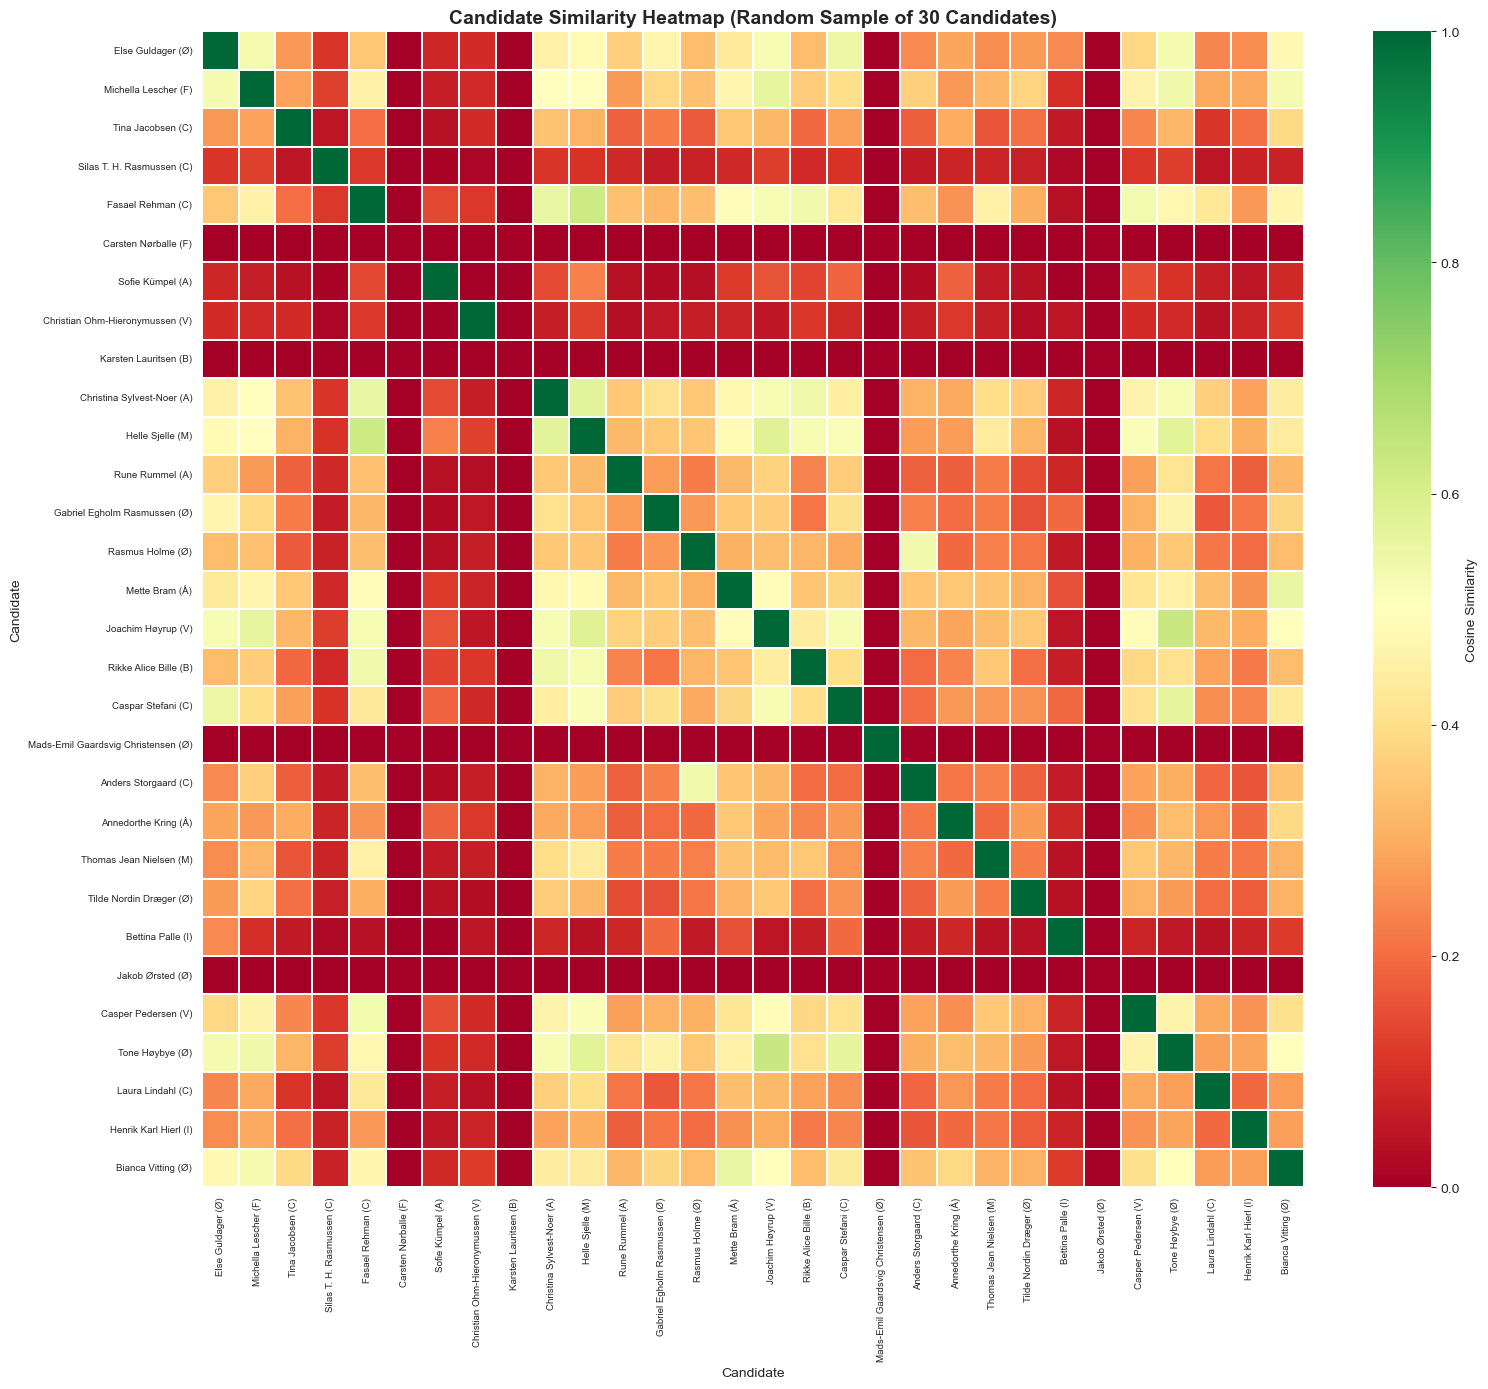


💡 Darker green = More similar | Red = More different


In [9]:
# Create heatmap for a sample of candidates (too many to show all)
sample_size = min(30, len(similarity_df))
sample_indices = np.random.choice(len(similarity_df), sample_size, replace=False)
sample_similarity = similarity_df.iloc[sample_indices, sample_indices]

plt.figure(figsize=(16, 14))
sns.heatmap(sample_similarity, 
            annot=False, 
            cmap='RdYlGn', 
            vmin=0, 
            vmax=1,
            cbar_kws={'label': 'Cosine Similarity'},
            linewidths=0.1)

plt.title(f'Candidate Similarity Heatmap (Random Sample of {sample_size} Candidates)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Candidate', fontsize=10)
plt.ylabel('Candidate', fontsize=10)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()
plt.show()

print("\n💡 Darker green = More similar | Red = More different")

## Within-Party vs Cross-Party Similarity

WITHIN-PARTY vs CROSS-PARTY SIMILARITY

Within-Party Similarity:
  Mean: 0.175
  Median: 0.136
  Std: 0.175

Cross-Party Similarity:
  Mean: 0.176
  Median: 0.135
  Std: 0.174

Difference: -0.002


/var/folders/bv/l3_9ykn56fg78stzg7b6_0nw0000gn/T/ipykernel_55546/2324306259.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Within-Party', 'Cross-Party'])


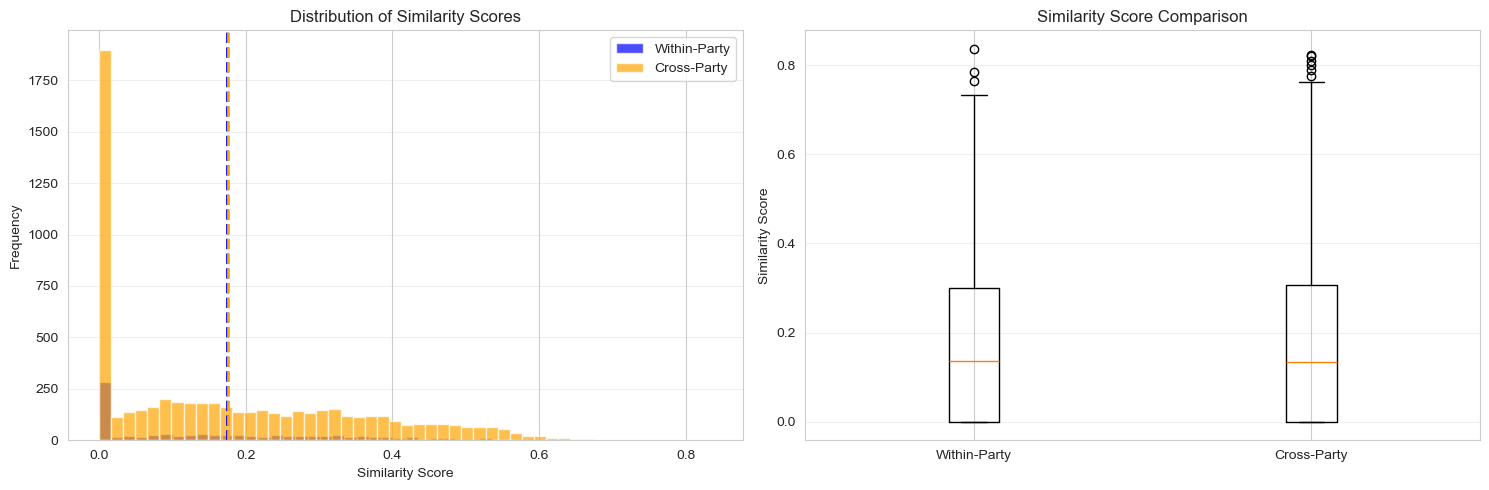

In [10]:
# Analyze within-party vs cross-party similarity
within_party_sim = similar_pairs_df[similar_pairs_df['same_party']]['similarity']
cross_party_sim = similar_pairs_df[~similar_pairs_df['same_party']]['similarity']

print("WITHIN-PARTY vs CROSS-PARTY SIMILARITY")
print("="*80)
print(f"\nWithin-Party Similarity:")
print(f"  Mean: {within_party_sim.mean():.3f}")
print(f"  Median: {within_party_sim.median():.3f}")
print(f"  Std: {within_party_sim.std():.3f}")

print(f"\nCross-Party Similarity:")
print(f"  Mean: {cross_party_sim.mean():.3f}")
print(f"  Median: {cross_party_sim.median():.3f}")
print(f"  Std: {cross_party_sim.std():.3f}")

print(f"\nDifference: {within_party_sim.mean() - cross_party_sim.mean():.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(within_party_sim, bins=50, alpha=0.7, label='Within-Party', color='blue')
axes[0].hist(cross_party_sim, bins=50, alpha=0.7, label='Cross-Party', color='orange')
axes[0].axvline(within_party_sim.mean(), color='blue', linestyle='--', linewidth=2)
axes[0].axvline(cross_party_sim.mean(), color='orange', linestyle='--', linewidth=2)
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Similarity Scores')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
data_to_plot = [within_party_sim, cross_party_sim]
axes[1].boxplot(data_to_plot, labels=['Within-Party', 'Cross-Party'])
axes[1].set_ylabel('Similarity Score')
axes[1].set_title('Similarity Score Comparison')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Party Cohesion Analysis

PARTY COHESION ANALYSIS
(How similar are candidates within the same party?)



,party,num_candidates,avg_similarity,median_similarity,std_similarity,min_similarity,max_similarity
9,O,2,0.466,0.466,NaN,0.466,0.466
8,M,5,0.321,0.333,0.168,0.124,0.565
3,Å,5,0.233,0.246,0.151,0.056,0.477
1,Ø,17,0.210,0.247,0.184,0.000,0.786
6,I,6,0.197,0.195,0.138,0.000,0.523
0,C,28,0.178,0.158,0.172,0.000,0.836
4,A,20,0.169,0.128,0.171,0.000,0.669
7,V,11,0.135,0.000,0.178,0.000,0.524
5,F,12,0.125,0.072,0.159,0.000,0.679
2,B,9,0.114,0.000,0.184,0.000,0.600


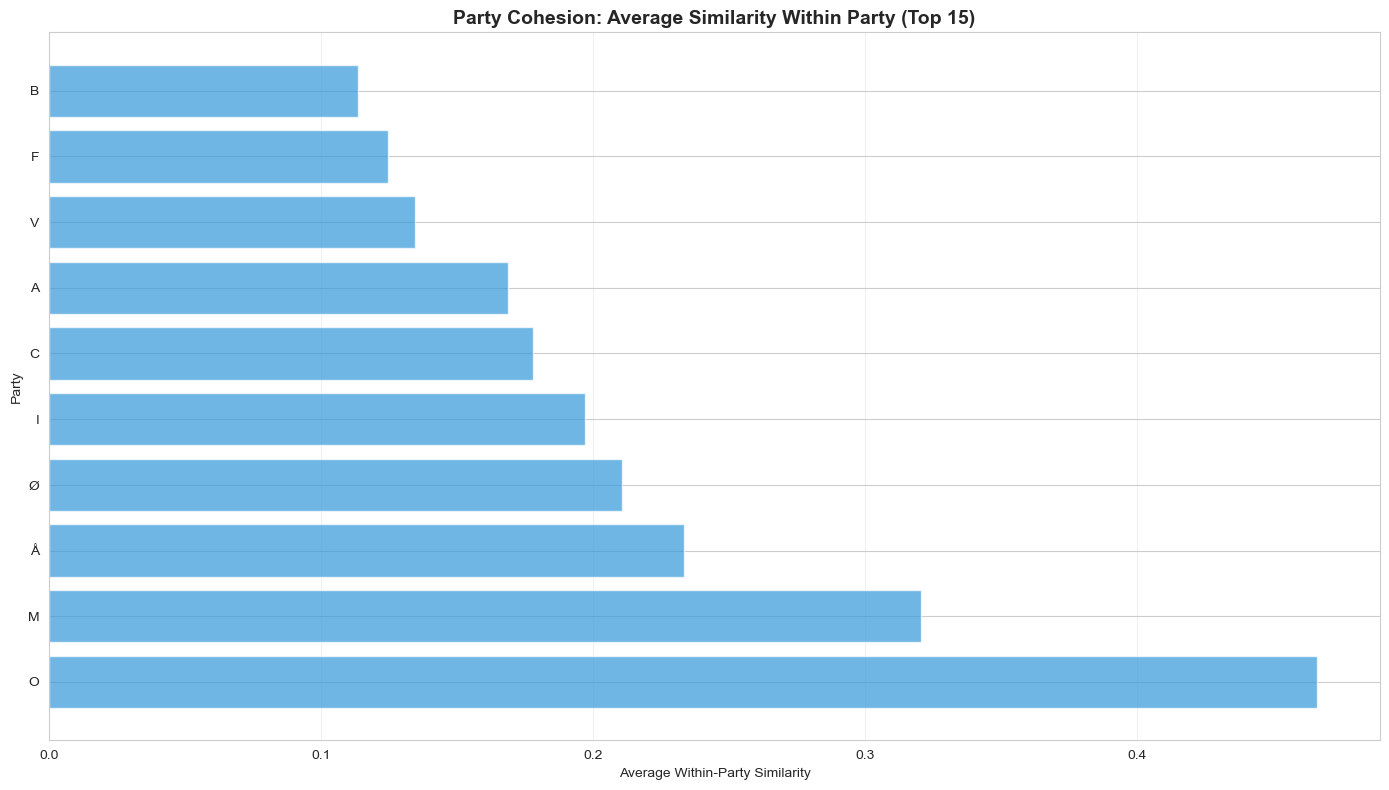

In [11]:
# Calculate average within-party similarity for each party
party_cohesion = []

for party in candidate_texts['party'].unique():
    party_candidates = candidate_texts[candidate_texts['party'] == party]['candidate_label'].tolist()
    
    if len(party_candidates) < 2:
        continue
    
    # Get similarity scores within this party
    party_pairs = similar_pairs_df[
        (similar_pairs_df['party_1'] == party) & 
        (similar_pairs_df['party_2'] == party)
    ]
    
    if len(party_pairs) > 0:
        party_cohesion.append({
            'party': party,
            'num_candidates': len(party_candidates),
            'avg_similarity': party_pairs['similarity'].mean(),
            'median_similarity': party_pairs['similarity'].median(),
            'std_similarity': party_pairs['similarity'].std(),
            'min_similarity': party_pairs['similarity'].min(),
            'max_similarity': party_pairs['similarity'].max()
        })

party_cohesion_df = pd.DataFrame(party_cohesion).sort_values('avg_similarity', ascending=False)

print("PARTY COHESION ANALYSIS")
print("="*80)
print("(How similar are candidates within the same party?)\n")
display(party_cohesion_df.round(3))

# Visualize
plt.figure(figsize=(14, 8))
top_parties = party_cohesion_df.head(15)
plt.barh(top_parties['party'], top_parties['avg_similarity'], color='#3498db', alpha=0.7)
plt.xlabel('Average Within-Party Similarity')
plt.ylabel('Party')
plt.title('Party Cohesion: Average Similarity Within Party (Top 15)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Clustering Analysis

In [12]:
# Perform K-means clustering
n_clusters = 5

print(f"Performing K-means clustering (k={n_clusters})...\n")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_matrix)

candidate_texts['cluster'] = clusters

print("✅ Clustering complete\n")
print("Cluster Distribution:")
print(candidate_texts['cluster'].value_counts().sort_index())

# Show cluster composition
print("\n" + "="*80)
print("CLUSTER COMPOSITION")
print("="*80)

for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_members = candidate_texts[candidate_texts['cluster'] == cluster_id]
    print(f"  Size: {len(cluster_members)} candidates")
    print(f"  Parties: {cluster_members['party'].value_counts().head(5).to_dict()}")
    print(f"  Avg Sentiment: {cluster_members['avg_sentiment'].mean():.3f}")
    print(f"  Sample members:")
    for member in cluster_members['candidate_label'].head(5):
        print(f"    - {member}")

Performing K-means clustering (k=5)...

✅ Clustering complete

Cluster Distribution:
cluster
0    50
1    53
2     3
3    11
4     2
Name: count, dtype: int64

CLUSTER COMPOSITION

Cluster 0:
  Size: 50 candidates
  Parties: {'C': 11, 'A': 8, 'F': 6, 'Ø': 5, 'B': 5}
  Avg Sentiment: -0.081
  Sample members:
    - Alexandra Dessoy (C)
    - Ane Rolsted (C)
    - Anne Eggen (Ø)
    - Anne Eskildsen (B)
    - Annedorthe Kring (Å)

Cluster 1:
  Size: 53 candidates
  Parties: {'Ø': 11, 'C': 11, 'A': 7, 'F': 5, 'V': 4}
  Avg Sentiment: -0.109
  Sample members:
    - Asbjørn Dalgaard (A)
    - August Gade (F)
    - Bianca Vitting (Ø)
    - Birgit Bech (Ø)
    - Bjarke Bisgaard Yolal (F)

Cluster 2:
  Size: 3 candidates
  Parties: {'C': 1, 'A': 1, 'V': 1}
  Avg Sentiment: -0.063
  Sample members:
    - Søren Brønchenburg (C)
    - Søren Dahlstrøm (A)
    - Søren Frost (V)

Cluster 3:
  Size: 11 candidates
  Parties: {'C': 4, 'A': 4, 'F': 1, 'M': 1, 'Ø': 1}
  Avg Sentiment: -0.109
  Sample memb

## PCA Visualization

Performing PCA for visualization...

✅ PCA complete
   Explained variance: 16.2%


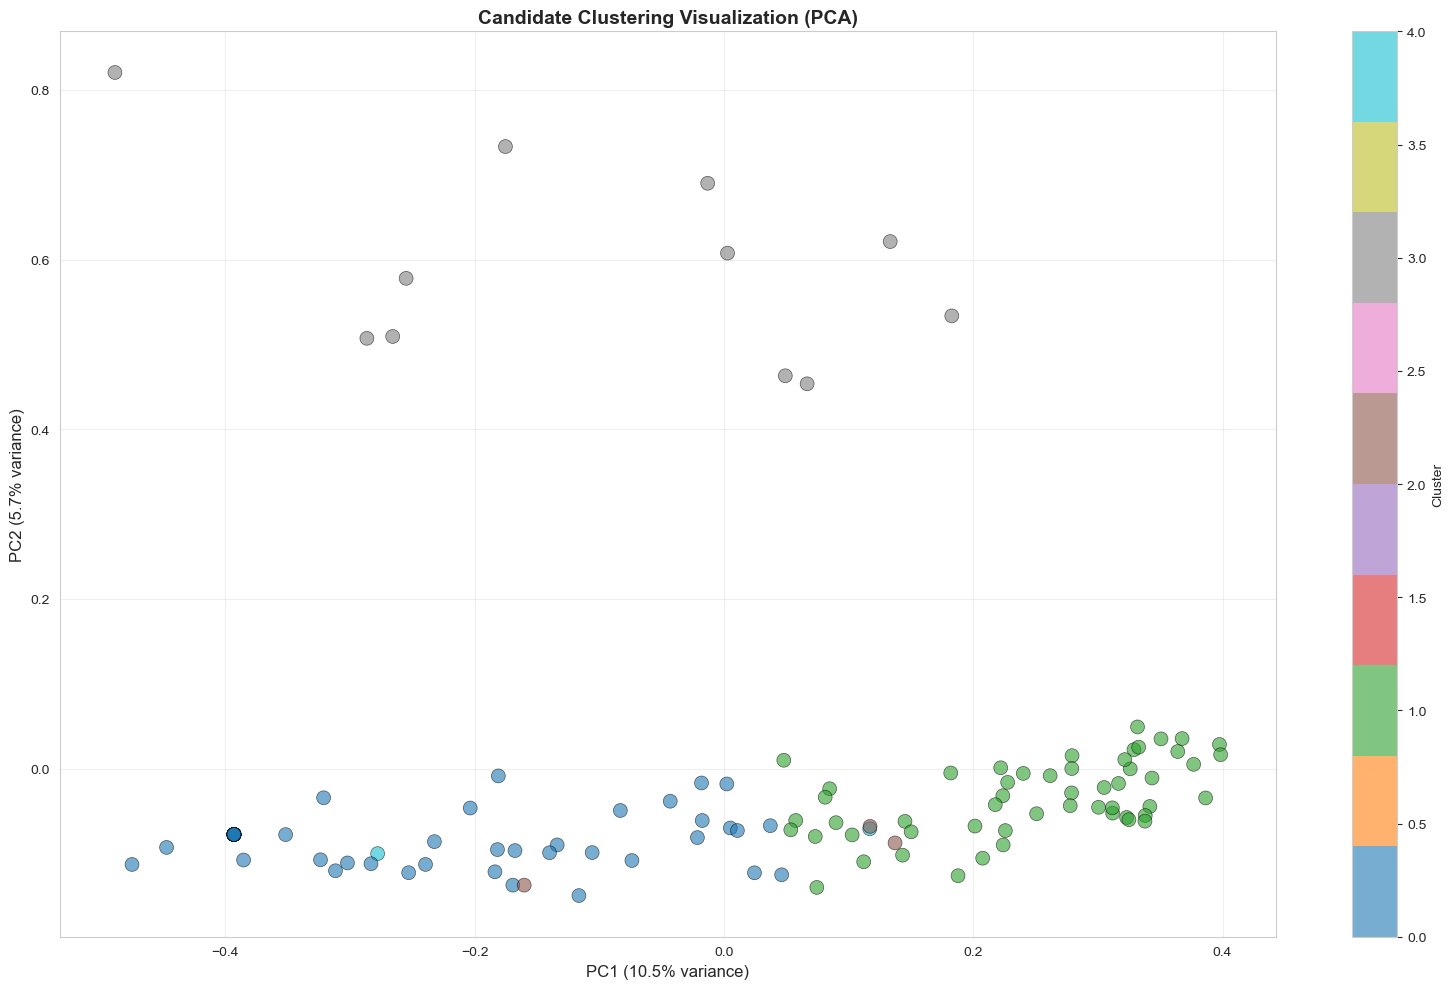

In [13]:
# Reduce dimensionality for visualization
print("Performing PCA for visualization...\n")

pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(tfidf_matrix.toarray())

candidate_texts['pca_x'] = pca_coords[:, 0]
candidate_texts['pca_y'] = pca_coords[:, 1]

print(f"✅ PCA complete")
print(f"   Explained variance: {sum(pca.explained_variance_ratio_):.1%}")

# Visualize
plt.figure(figsize=(16, 10))
scatter = plt.scatter(candidate_texts['pca_x'], 
                     candidate_texts['pca_y'],
                     c=candidate_texts['cluster'],
                     cmap='tab10',
                     s=100,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Candidate Clustering Visualization (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cross-Party Alliances (Most Similar Across Parties)

In [14]:
# Find strongest cross-party similarities
print("POTENTIAL CROSS-PARTY ALLIANCES")
print("="*80)
print("(Candidates from different parties with highest similarity)\n")

cross_party = similar_pairs_df[~similar_pairs_df['same_party']].head(30)
display(cross_party)

# Analyze which parties have most cross-party similarities
party_pair_counts = {}

for _, row in cross_party.iterrows():
    pair = tuple(sorted([row['party_1'], row['party_2']]))
    if pair not in party_pair_counts:
        party_pair_counts[pair] = {'count': 0, 'avg_similarity': []}
    party_pair_counts[pair]['count'] += 1
    party_pair_counts[pair]['avg_similarity'].append(row['similarity'])

party_alliances = []
for pair, data in party_pair_counts.items():
    party_alliances.append({
        'party_1': pair[0],
        'party_2': pair[1],
        'similar_pairs_count': data['count'],
        'avg_similarity': np.mean(data['avg_similarity'])
    })

party_alliances_df = pd.DataFrame(party_alliances).sort_values('avg_similarity', ascending=False)

print("\n\nMOST ALIGNED PARTY PAIRS")
print("="*80)
display(party_alliances_df.head(20))

POTENTIAL CROSS-PARTY ALLIANCES
(Candidates from different parties with highest similarity)



,candidate_1,candidate_2,similarity,party_1,party_2,same_party
6696,Rasmus Edelberg (A),Rasmus Holme (Ø),0.823335,A,Ø,False
3781,Henrik Karl Hierl (I),Henrik Kragelund (C),0.819860,I,C,False
5590,Mads Freund (M),Mads Simonsen (A),0.810416,M,A,False
4813,Julius Lundsteen (F),Klaus Eskelund (C),0.800872,F,C,False
6280,Nikolaj Bøgh (C),Nikolaj Rachdi Bührmann (F),0.788169,C,F,False
4941,Kim Christiansen (A),Kim Hjerrild (Å),0.774878,A,Å,False
6944,Søren Brønchenburg (C),Søren Frost (V),0.762815,C,V,False
2969,Elias Lederhaas (C),Malte Mathies Løcke (A),0.757502,C,A,False
6943,Søren Brønchenburg (C),Søren Dahlstrøm (A),0.749708,C,A,False
168,Anders Storgaard (C),Julius Lundsteen (F),0.727923,C,F,False




MOST ALIGNED PARTY PAIRS


,party_1,party_2,similar_pairs_count,avg_similarity
4,A,Å,1,0.774878
1,C,I,2,0.732206
0,A,Ø,2,0.726952
3,C,F,6,0.724154
2,A,M,2,0.723534
5,C,V,2,0.715018
6,A,C,5,0.697292
7,B,Ø,1,0.673561
8,F,Ø,1,0.669328
10,B,F,1,0.658022


## Export Results

In [15]:
# Save similarity matrix
similarity_df.to_csv('candidate_similarity_matrix.csv', encoding='utf-8')
print(f"✅ Similarity matrix saved to: candidate_similarity_matrix.csv")

# Save similar pairs
similar_pairs_df.to_csv('candidate_similar_pairs.csv', index=False, encoding='utf-8')
print(f"✅ Similar pairs saved to: candidate_similar_pairs.csv")

# Save party cohesion
party_cohesion_df.to_csv('party_cohesion.csv', index=False, encoding='utf-8')
print(f"✅ Party cohesion saved to: party_cohesion.csv")

# Save clustering results
candidate_texts[['candidate_label', 'name', 'party', 'cluster', 'avg_sentiment']].to_csv(
    'candidate_clusters.csv', index=False, encoding='utf-8'
)
print(f"✅ Clustering results saved to: candidate_clusters.csv")

# Save cross-party alliances
party_alliances_df.to_csv('cross_party_alliances.csv', index=False, encoding='utf-8')
print(f"✅ Cross-party alliances saved to: cross_party_alliances.csv")

print(f"\n📊 Analysis Complete!")
print(f"   Files generated: 5")

✅ Similarity matrix saved to: candidate_similarity_matrix.csv
✅ Similar pairs saved to: candidate_similar_pairs.csv
✅ Party cohesion saved to: party_cohesion.csv
✅ Clustering results saved to: candidate_clusters.csv
✅ Cross-party alliances saved to: cross_party_alliances.csv

📊 Analysis Complete!
   Files generated: 5


## Summary Report

In [16]:
print("\n" + "="*100)
print("PARTY OVERLAPS & CANDIDATE SIMILARITY ANALYSIS - SUMMARY")
print("="*100)

print(f"\n📊 Dataset:")
print(f"   Total candidates analyzed: {len(candidate_texts)}")
print(f"   Total parties: {candidate_texts['party'].nunique()}")
print(f"   Total candidate pairs: {len(similar_pairs_df)}")

print(f"\n🤝 Most Similar Pair:")
most_similar = similar_pairs_df.iloc[0]
print(f"   {most_similar['candidate_1']}")
print(f"   {most_similar['candidate_2']}")
print(f"   Similarity: {most_similar['similarity']:.3f}")
print(f"   Same party: {most_similar['same_party']}")

print(f"\n↔️ Most Different Pair:")
most_different = similar_pairs_df.iloc[-1]
print(f"   {most_different['candidate_1']}")
print(f"   {most_different['candidate_2']}")
print(f"   Similarity: {most_different['similarity']:.3f}")
print(f"   Same party: {most_different['same_party']}")

print(f"\n🏛️ Party Cohesion:")
print(f"   Most cohesive party: {party_cohesion_df.iloc[0]['party']}")
print(f"   Avg similarity: {party_cohesion_df.iloc[0]['avg_similarity']:.3f}")
print(f"   Least cohesive party: {party_cohesion_df.iloc[-1]['party']}")
print(f"   Avg similarity: {party_cohesion_df.iloc[-1]['avg_similarity']:.3f}")

print(f"\n🔀 Cross-Party Similarity:")
print(f"   Within-party avg: {within_party_sim.mean():.3f}")
print(f"   Cross-party avg: {cross_party_sim.mean():.3f}")
print(f"   Difference: {within_party_sim.mean() - cross_party_sim.mean():.3f}")

if len(party_alliances_df) > 0:
    print(f"\n🤝 Strongest Cross-Party Alliance:")
    top_alliance = party_alliances_df.iloc[0]
    print(f"   {top_alliance['party_1']} ↔ {top_alliance['party_2']}")
    print(f"   Avg similarity: {top_alliance['avg_similarity']:.3f}")
    print(f"   Similar pairs: {top_alliance['similar_pairs_count']}")

print(f"\n📊 Clustering:")
print(f"   Number of clusters: {n_clusters}")
print(f"   Largest cluster: Cluster {candidate_texts['cluster'].value_counts().idxmax()}")
print(f"   Size: {candidate_texts['cluster'].value_counts().max()} candidates")

print("\n" + "="*100)


PARTY OVERLAPS & CANDIDATE SIMILARITY ANALYSIS - SUMMARY

📊 Dataset:
   Total candidates analyzed: 119
   Total parties: 14
   Total candidate pairs: 7021

🤝 Most Similar Pair:
   Else Marie Thorgaard (C)
   Marie Budtz Andersen (C)
   Similarity: 0.836
   Same party: True

↔️ Most Different Pair:
   Torben Grinderslev (C)
   Vibeke Westh (A)
   Similarity: 0.000
   Same party: False

🏛️ Party Cohesion:
   Most cohesive party: O
   Avg similarity: 0.466
   Least cohesive party: B
   Avg similarity: 0.114

🔀 Cross-Party Similarity:
   Within-party avg: 0.175
   Cross-party avg: 0.176
   Difference: -0.002

🤝 Strongest Cross-Party Alliance:
   A ↔ Å
   Avg similarity: 0.775
   Similar pairs: 1

📊 Clustering:
   Number of clusters: 5
   Largest cluster: Cluster 1
   Size: 53 candidates

